# Chapter 71 (Adversarial Attacks)

### This code generates figure 7 in Chapter 71: Adversarial Attacks (vol. III)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. tqdm

In [1]:
import numpy as np 
import scipy 
import matplotlib.pyplot as plt
from functions import *

## Example 71.2 (Classification of handwritten digits)

We reconsider the feedforward neural network that was employed in Example 70.3 to classify  handwritten digits using the MNIST dataset. Recall that this dataset consists of 60,000 labeled training samples and 10,000 labeled testing samples. Each entry in the dataset is a 28 $\times$ 28 grayscale image, which we transform into an $M=784$-long feature vector, $h_n$. Each pixel in the image and, therefore, each entry in $h_n$, assumes integer values in the range $[0,255]$. Every feature vector (or image) is assigned an integer label in the range $0$--$9$ depending on which digit the image corresponds to. The earlier Fig. 65.12 shows randomly selected images from the training dataset. 
 
 
We pre-process the images (or the corresponding feature vectors $\{h_n\}$) by scaling their entries by $255$ (so that they assume values in the range $[0,1]$). We subsequently compute the mean feature vectors for the training set and for the test set. We center the scaled feature vectors around these means in both sets. The earlier Fig. 65.12 shows randomly selected images for the digits $\{0,1\}$ before and after processing.

In [2]:
# The user can set five flags:

# 1) input data: MNIST or CIFAR10
choose_data = 1  # 1 = MNIST,  2 = CIFAR

# 2) Use dropout or not
dropout = 1  # 1: use dropout; 0: do not use dropout

# 3) type of risk function
type_ = 3  # 1: sigmoid, 2: tanh, 3: rectifier

# 4) type of risk function
cost = 1  # 0: least-squares, 1: cross-entropy

# 5) Choose if the output layer should be softmax
softmax = 1  # set to 1 to use softmax; otherwise set to zero

if choose_data == 1:
    # MNIST dataset
    mnist_data = scipy.io.loadmat("data/mnist_normalized.mat") # loaded mnist data; features are centered and variance-normalized
    features_train = mnist_data["train_features_norm"] # 60,000 x 784
    labels_train = mnist_data["train_norm_labels"] # 10 digit labels 
    features_test = mnist_data["test_features_norm"] # 10,000 x 784
    labels_test = mnist_data["test_norm_labels"] # 10 digit labels

    n2 = 512 # number of nodes in hidden layer 2
    n3 = 512 # number of nodes in hidden layer 3

else:
    # CIFAR-10 dataset
    data_batch_1 = scipy.io.loadmat("data/data_batch_1_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = data_batch_1["train_features_norm_1"] # 10,000 x 3072
    labels_train = data_batch_1["train_labels_norm_1"] # labels 0, 1, ..., 9

    data_batch_2 = scipy.io.loadmat("data/data_batch_2_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_2["train_features_norm_2"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_2["train_labels_norm_2"]]) # labels 0, 1, ..., 9

    data_batch_3 = scipy.io.loadmat("data/data_batch_3_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_3["train_features_norm_3"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_3["train_labels_norm_3"]]) # labels 0, 1, ..., 9

    data_batch_4 = scipy.io.loadmat("data/data_batch_4_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_4["train_features_norm_4"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_4["train_labels_norm_4"]]) # labels 0, 1, ..., 9

    data_batch_5 = scipy.io.loadmat("data/data_batch_5_normalized.mat") #loaded CIFAR-10 data; features are centered and variance-normalized.
    features_train = np.concatenate([features_train, data_batch_5["train_features_norm_5"]]) # 10,000 x 3072
    labels_train = np.concatenate([labels_train, data_batch_5["train_labels_norm_5"]]) # labels 0, 1, ..., 9

    test_data_batch = scipy.io.loadmat("data/test_batch_normalized.mat") # loaded CIFAR-10 data; features are centered and variance-normalized.
    features_test = test_data_batch["test_features_norm"]
    labels_test = test_data_batch["test_labels_norm"]

    n2 = 2048 # number of nodes in hidden layer 2
    n3 = 2048 # number of nodes in hidden layer 3

number_of_classes = 10
mu = 0.001 # step-size
rho = 0.0001 # l2-regularization
number_of_passes = 200 # epochs

# dropout parameters
p_vec = [0.1, 0.5, 0.5] # Bernoulli probabilities for input layer and the two hidden layers value of p = probability of node turned off

# Choose type of activation function
if type_ == 1: #1: sigmoid, 2: tanh, 3: rectifier
    activation = "sigmoid"
elif type_ == 2:
    activation = "tanh" 
elif type_ == 3:
    activation = "rectifier"

if cost == 1: # to make sure that when cross-entropy is used, softmax is also used
    softmax = 1

if activation == "rectifier": # to make sure that when rectifier is used, softmax is also used
    softmax = 1

L = 4 # total number of layers, including input and output layers --> L-2 hidden layers

In [3]:
number_of_passes = 10
Wcell, ThetaCell = train_feedforward_neural_network(
    L, number_of_classes, mu, rho, number_of_passes, features_train, labels_train,
    n2, n3, dropout, activation, softmax, p_vec, cost)

  0%|          | 0/60000 [00:00<?, ?it/s]

100%|██████████| 60000/60000 [05:05<00:00, 196.35it/s]


In [4]:
N_test = features_test.shape[0]

cost = 1 # 1: cross-entropy; 0: least-squares
softmax = 1 # output layer uses softmax

type_ = 2 # 1: sigmoid; 2: rectifier

nL = number_of_classes # size of output layer, which is equal to the number of labels
n1 = features_test.shape[-1] # size of input layer, which is equal to M
n4 = nL # same as output layer
Q = nL # size of output layer; same as nL; which the number of classes as well.

yCell = [None]*L # to save the y vectors across layers
zCell = [None]*L # to save the z vectors across layers

RT = 4 # number of tests to run
H_original = np.zeros((n1, RT)) # choose RT images
gamma_original = np.zeros(RT) # their labels 

H_FGSM = np.zeros((n1, RT)) # images modified by FGSM method
gamma_FGSM = np.zeros(RT)

H_JSMA = np.zeros((n1, RT)) # images modified by JSMA method
gamma_JSMA = np.zeros(RT)

H_DF = np.zeros((n1, RT)) # images modified by DF method
gamma_DF = np.zeros(RT)

labels_test = labels_test.reshape(-1)
for r in range(RT): # generating three random examples
    n = np.random.randint(N_test) # select a random sample
    h = features_test[n]
    m = int(labels_test[n]) # labels assumed to be nonnegative: 0, 1, 2, ...
    gamma = np.zeros(Q) # transform the label into a one-hot encoded vector
    gamma[m] = 1
    q = m
    eq = np.zeros(Q)
    eq[q] = 1
    H_original[:, r] = h 
    gamma_original[r] = m 

    yCell[0] = h 
    for ell in range(L-1): # forward propagation
        Weight = Wcell[ell]
        theta = ThetaCell[ell]
        y = yCell[ell]
        z = Weight@y - theta 
        zCell[ell+1] = z.copy()

        K = z.shape[0]
        y = np.zeros(K) # generating next y 

        for k in range(K):
            y[k] = max(0, z[k])
    
        yCell[ell+1] = y.copy() # save y_{ell+1}

    zL = z.copy()
    yL = yCell[-1]

    K = zL.shape[0]

    gamma_hat = np.exp(zL)/np.exp(zL).sum()

    ax = np.max(gamma_hat) # find location of largest probability
    idx = np.argmax(gamma_hat) 

    q_star = idx

    # FGSM (Fast Gradient Sign Method)
    zCella = [None]*L
    dCella = [None]*L 

    epsilon = 0.005

    ha = h.copy()
    gamma_a = gamma.copy()
    gamma_hat_a = gamma_hat.copy()
    q_star_a = q_star.copy()
    zCella = zCell.copy()

    ITER = 20 # maximum number of iterations
    counter = 1

    while (counter <= ITER) and (q_star_a == q_star):
        deltaL = (gamma_hat_a - gamma_a) # boundary condition for cross-entropy risk
        dCella[-1] = deltaL 

        for ell in range(L-1, 0, -1):
            Weight = Wcell[ell-1]
            delta = dCella[ell]

            if ell >= 2: # computing next delta only for ell >= 2
                z = zCella[ell-1]
                K = z.shape[0]
                J = np.zeros((K, K))
                for k in range(K):
                    if z[k] <= 0: # set, by convention, f'(z) to zero at z=0 for the rectifier function
                        J[k, k] = 0
                    else:
                        J[k, k] = 1
                
                dCella[ell-1] = J@((Weight).T@delta)
            else:
                dCella[0] = (Weight).T@dCella[1]
        
        delta1 = dCella[0]
        hFGSM = ha + epsilon*sign_vector(delta1) # perturbed image
        H_FGSM[:, r] = hFGSM 

        yCellFGSM = [None]*L 
        zCellFGSM = [None]*L 

        yCellFGSM[0] = hFGSM # let us feed it forward and determine its predicted class
        for ell in range(L-1): # forward propagation
            Weight = Wcell[ell]
            theta = ThetaCell[ell]
            y = yCellFGSM[ell]
            z = Weight@y - theta 
            zCellFGSM[ell+1] = z

            K = z.shape[0]
            y = np.zeros(K) # generating next y
            for k in range(K):
                y[k] = max(0, z[k])
            
            yCellFGSM[ell+1] = y.copy() 
        zL = z.copy()
        yL = yCellFGSM[-1]

        K = zL.shape[0]
        gamma_predicted = np.exp(zL)/np.exp(zL).sum()

        ax = np.max(gamma_predicted) # find location of largest probability
        idx = np.argmax(gamma_predicted) 

        q_FGSM = idx
        gamma_FGSM[r] = q_FGSM

        counter += 1
        ha = hFGSM 
        gamma_a = gamma # original gamma stays 
        q_star_a = q_FGSM 
        zCella = zCellFGSM 
    
    # JSMA (Jacobian Saliency Map Approach)

    zCella = [None]*L 
    dCella = [None]*L 

    ha = h.copy()
    gamma_a = gamma.copy()
    q_star_a = q_star.copy()
    zCella = zCell.copy()

    ITER = 20
    counter = 1

    epsilon = 0.05
    q_target  = 2 # desired target class is 2 (since classes are numbered 0 to 9)
    M = n1 # dimension of feature vectors
    P = round(M/20) # how many of the feature entries to perturb

    LambdaCell = [None]*L 
    LambdaCell[0] = np.eye(M)

    if q_star_a == q_target:
        gamma_JSMA[r] = q_target-1
        H_JSMA[:, r] = ha.copy()
    else:
        while(counter <= ITER) and (q_star_a != q_target):
            for ell in range(L-1): # forward propagation
                Weight = Wcell[ell]
                Lambda = LambdaCell[ell]
                z = zCell[ell+1]

                K = z.shape[0]
                J = np.zeros((K, K))
                for k in range(K):
                    if z[k] <= 0: # set, by convention, f'(z) to zero at z=0 for the rectifier function
                        J[k, k] = 0
                    else:
                        J[k, k] = 1
                Lambda = J@Weight@Lambda 
                LambdaCell[ell+1] = Lambda
            LambdaL = LambdaCell[-1]

            Svec = np.zeros(M)
            for j in range(M):
                sumx = sum(LambdaL[:, j])-LambdaL[q_target, j]
                if (LambdaL[q_target, j] < 0) or (sumx > 0):
                    Svec[j] = 0
                else:
                    Svec[j] = LambdaL[q_target, j] * abs(sumx)
            Sx = np.sort(Svec)[::-1]
            Idx = np.argsort(Svec)[::-1] # order from largest to smallest
            hJSMA = ha.copy()
            hJSMA[Idx[:P]] = hJSMA[Idx[:P]] + epsilon # perturb P of them
            H_JSMA[:, r] = hJSMA 

            yCellJSMA = [None]*L
            zCellJSMA = [None]*L 

            yCellJSMA[0] = hJSMA # let us feed it forward and determine its predicted class
            for ell in range(L-1): # forward propagation
                Weight = Wcell[ell]
                theta = ThetaCell[ell]
                y = yCellJSMA[ell]
                z = Weight@y - theta
                zCellJSMA[ell+1] = z.copy()

                K = z.shape[0]
                y = np.zeros(K) # generating next y
                for k in range(K):
                    y[k] = max(0, z[k])
                
                yCellJSMA[ell+1] = y.copy() # save y_{ell+1}
            
            zL = z.copy()
            yL = yCellJSMA[-1]
            K = zL.shape[0]
            gamma_predicted = np.exp(zL)/np.exp(zL).sum()

            ax = np.max(gamma_predicted) # find location of largest probability
            idx = np.argmax(gamma_predicted) 

            q_JSMA = idx
            gamma_JSMA[r] = q_JSMA 

            counter += 1
            ha = hJSMA.copy()
            gamma_a = gamma.copy() # original gamma stays
            gamma_hat_a = gamma_predicted.copy()
            q_star_a = q_JSMA
            zCella = zCellJSMA.copy()

    # DeepFool technique

    zCella = [None]*L 
    dCella = [None]*L 

    ha = h.copy()
    gamma_a = gamma.copy()
    gamma_hat_a = gamma_hat.copy()
    q_star_a = q_star.copy()
    zCella = zCell.copy()

    ITER = 20
    counter = 1

    epsilon = 0.0001
    M = n1 # dimension of feature vectors

    LambdaCellDF = [None]*L # each q-th column is the vector lambda_{ell}^q
    Iden = np.eye(Q) # identify matrix
    LambdaL = np.zeros((Q, Q))
    lambda_L_q = np.zeros(Q)

    while (counter <= ITER) and (q_star_a == q_star):
        for q in range(Q):
            eq = Iden[:, q] # q-th basis vector
            lambda_L_q = eq - gamma_hat_a[q]*gamma_hat_a
            LambdaL[:, q] = lambda_L_q
        LambdaCellDF[-1] = LambdaL 

        for ell in range(L-1, 1, -1):
            Lambda = LambdaCellDF[ell]
            Weight = Wcell[ell-1]
            z = zCella[ell-1]

            K = z.shape[0]
            J = np.zeros((K, K))
            for k in range(K):
                if z[k] <= 0: # set, by convention, f'(z) to zero at z=0 for the rectifier function
                    J[k, k] = 0
                else:
                    J[k, k] = 1
            Lambdax = J@(Weight).T@Lambda 
            LambdaCellDF[ell-1] = Lambdax.copy()
        
        Weight = Wcell[0]
        Lambda2 = LambdaCellDF[1]
        Lambda1 = (Weight).T@Lambda2 

        xvec = np.zeros(Q)
        bvec = Lambda1[:, q_star_a]
        for q in range(Q):
            if q != q_star_a:
                avec = Lambda1[:, q]
                xvec[q] = np.abs(gamma_hat[q]-gamma_hat[q_star_a])/(np.linalg.norm(avec-bvec))
        
        xmin = np.sort(xvec)
        idx = np.argsort(xvec)
        if idx[0] == q_star_a:
            qo = idx[1]
        else:
            qo = idx[0]
        
        avec = Lambda1[:, qo]
        delta_h = -((1+epsilon)*(gamma_hat[qo]-gamma_hat[q_star_a]))/(np.linalg.norm(avec-bvec)**2)
        delta_h = delta_h*(avec-bvec)
        hDeepFool = ha + delta_h 
        H_DF[:, r] = hDeepFool.copy()

        yCellDF = [None]*L 
        zCellDF = [None]*L 

        yCellDF[0] = hDeepFool # let us feed it forward and determine its predicted class
        for ell in range(L-1): # forward propagation
            Weight = Wcell[ell]
            theta = ThetaCell[ell]
            y = yCellDF[ell]
            z = Weight@y - theta
            zCellDF[ell+1] = z.copy()

            K = z.shape[0]
            y = np.zeros(K) # generating next y
            for k in range(K):
                y[k] = max(0, z[k])
            yCellDF[ell+1] = y.copy()
        zL = z.copy()

        K = zL.shape[0]

        gamma_predicted = np.exp(zL)/np.exp(zL).sum()

        ax = np.max(gamma_predicted) # find location of largest probability
        idx = np.argmax(gamma_predicted)
        q_DF = idx
        gamma_DF[r] = q_DF 

        counter += 1
        ha = hDeepFool.copy()
        gamma_a = gamma.copy() # original gamma stays
        gamma_hat_a = gamma_predicted.copy()
        q_star_a = q_DF 
        zCella = zCellDF.copy()


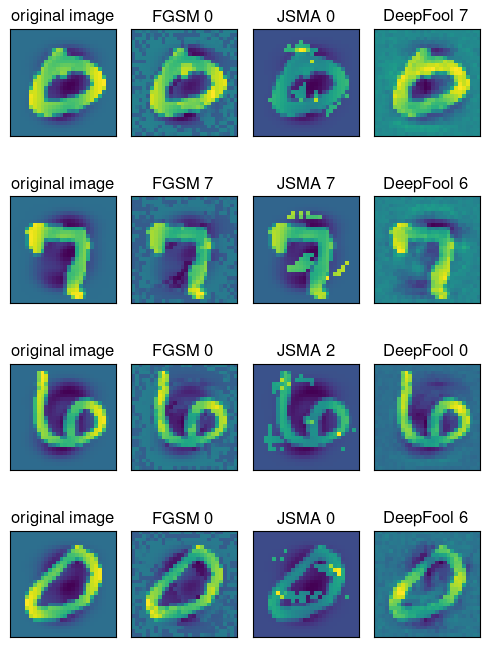

In [19]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=5, 7
fig = plt.figure()

for r in range(RT):
    original_image = H_original[:, r].reshape((28, 28))
    fgsm = H_FGSM[:, r].reshape((28, 28))
    jsma = H_JSMA[:, r].reshape((28, 28))
    df = H_DF[:, r].reshape((28, 28))

    ax = fig.add_subplot(4, 4, r*4 + 1)
    ax.imshow(original_image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("original image")

    ax = fig.add_subplot(4, 4, r*4 + 2)
    ax.imshow(fgsm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"FGSM {int(gamma_FGSM[r])}")

    ax = fig.add_subplot(4, 4, r*4 + 3)
    ax.imshow(jsma)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"JSMA {int(gamma_JSMA[r])}")

    ax = fig.add_subplot(4, 4, r*4 + 4)
    ax.imshow(df)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"DeepFool {int(gamma_DF[r])}")

fig.tight_layout()

plt.savefig("figs/fig-7.pdf")

plt.show()

**Figure 71.7** Four randomly selected handwritten digits applied to a trained feedforward neural network with four layers. The three rightmost columns show the perturbed images under each of the attack methods: FGSM, JSMA, and DeepFool, along with the corresponding predicted labels for the images.

We train a feedforward neural network with a total of four  layers: one input layer, one output layer, and two hidden layers. The size of the input layer is $n_1=784$ (which agrees with the size of the feature vectors), while the size of the output layer is $n_4=10$ (which agrees with the number of classes). The size of the hidden layers is set to $n_2=n_3=512$ neurons. We assume the internal nodes employ sigmoidal activation functions, while the output layer relies on a softmax mapping. We train  the network using a regularized cross-entropy criterion with parameters

$$
\mu=0.001,\;\;\;\rho=0.0001 \tag{71.81}
$$

We run a stochastic-gradient version of the backpropagation algorithm (65.82) with mini-batches of size  1.
We perform $P=200$ passes over the training data; the data is randomly reshuffled at the start of each pass. 
 
At the end of this training phase, we select four random feature vectors and perturb them according to the iterated-FGSM scheme (71.25) for untargeted attacks, the iterated-JSMA scheme (71.38) for targeted attacks, and the DeepFool scheme (71.80). For all three schemes we cap the number of iterations to $20$. For JSMA we choose class $q=2$ as the target label.  The results are shown in Fig. 71.7. The first column shows the selected handwritten digits; they are all correctly identified by the trained network. The second column shows the perturbed images by the FGSM method (using $\epsilon=0.005$); on top of each image, we indicate the label assigned to the perturbed image by the network. The third column shows the perturbed images by the JSMA scheme (using $\epsilon=0.05$); all of them were assigned to class $q=2$ by the network. The last column shows the perturbed images under DeepFool and the corresponding assigned labels (using $\epsilon=0.0001$). It appears from this simulation that FGSM and DeepFool are able to generate adversarial samples more easily than JSMA; the latter required larger  perturbations.